Notebook purpose

- Check whether there is a reliable way to identify savings transactions

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 2.28 seconds
Time for read_sample    : 4.85 minutes
(14,839,981, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1859849,2012-11-05,57,-700.0,faster payments receipt ref mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,8504.292969,22136.039062,2.397678
1,1859848,2012-11-08,57,-900.0,faster payments receipt from mdbremoved,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2012-10-23,274000,2020-08-16 07:24:00,santander,current,2014-07-18,2017-08-15,False,14829.769531,NaN,NaN,NaN,current account,u,201211,9404.292969,22136.039062,2.397678


## Tags

The simplest approach to identify savings is to use MDB auto tags. I have grouped all relevant auto tags into a `tag` called *savings*, which is a subgroup of the `tag_group` *transfters*.

In [8]:
tc.transfers_subgroups["savings"]

['general savings',
 'investment - other',
 'investments or shares',
 'isa',
 'pension or investments',
 'saving (general)',
 'savings (general)',
 'savings']

But there are not enough txns and users to work with, so I won't use these.

In [9]:
savings = df[df.tag.eq("savings")]
hd.txns_and_users(savings, df)

df1 has 19,207 txns across 1176 users (0.3% and 43.3% of df2).


## Savings account transfers

An alternative is to look at flows into and out of savings accounts. We could define something like 'monthly net savings' as the the sum of all inflows and outflows into a users savings accounts during a month.

In [10]:
savings = df[df.account_type.eq("savings")]
credits = savings[~savings.debit]
debits = savings[savings.debit]

There are many more transactions across many more users than for tags above.

In [11]:
hd.txns_and_users(savings, df)

df1 has 163,681 txns across 1557 users (2.2% and 57.3% of df2).


Plot distributions of monthly inflows, outflows, and net savings.

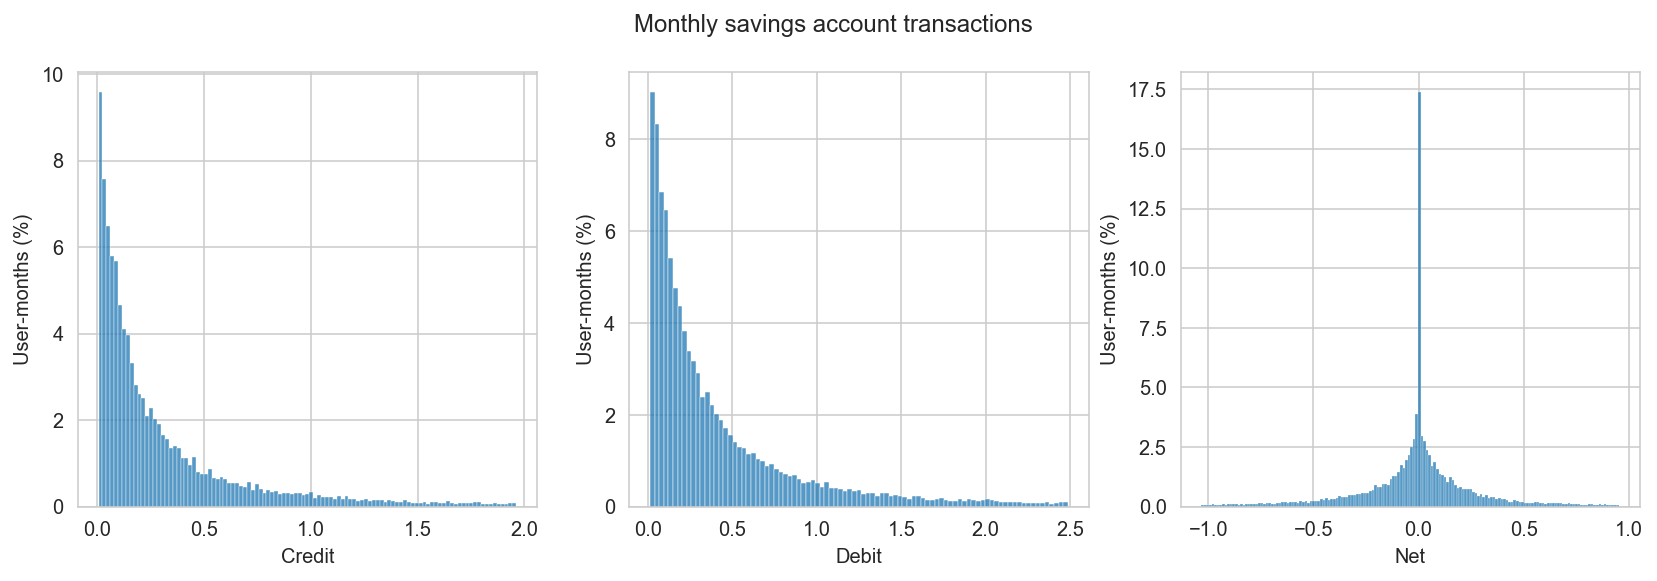

In [71]:
def keep_savings_txns(df):
    mask = df.account_type.eq("savings") & ~df.tag_auto.str.contains(
        "interest", na=False
    )
    return df[mask]


def agg_and_scale(df):
    """Aggregates df into inflows, outflows, and net, by user month
    and scales flows by user's monthly income.
    """
    df = df.copy()
    df["debit"] = df.debit.replace({True: "debit", False: "credit"})
    month = pd.Grouper(key="date", freq="m")
    monthly_flows = (
        df.groupby(["user_id", month, "income", "debit"])
        .amount.sum()
        .abs()
        .unstack()
        .assign(net=lambda df: df.credit - df.debit)
    )
    monthly_income = monthly_flows.index.get_level_values("income") / 12
    scaled_flows = monthly_flows.div(monthly_income, axis="rows")
    return scaled_flows.reset_index("income", drop=True)


def trim_column_values(df, pct=5):
    return df.apply(hd.trim, pct=pct)


def make_data(df):
    return keep_savings_txns(df).pipe(agg_and_scale).pipe(trim_column_values)


def make_figure(df):
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("Monthly savings account transactions")
    ylabel = "User-months (%)"
    for i, col in enumerate(df.columns):
        sns.histplot(x=df[col], stat="percent", ax=ax[i])
        ax[i].set(xlabel=col.title(), ylabel=ylabel)
    return fig, ax


def monthly_savings(df):
    data = make_data(df)
    fig, ax = make_figure(data)
    return fig


k = monthly_savings(df)

## Non-standing-order transactions only

todo if needed

In [21]:
savings.desc.value_counts()[:5]

mdbremoved                  32161
mdbremoved ft                5186
save the change bp           4713
transfer from mdbremoved     4067
mdbremoved tfr               4049
Name: desc, dtype: int64